In [1]:
import warnings
from collections import namedtuple
from math import ceil

warnings.simplefilter(action="ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import argparse
from algorithms.snn import SNN
from algorithms.snn_biclustering import SNNBiclustering
from algorithms.fill_tensor_ALS import ALS
from sklearn.metrics import r2_score
import time
import matplotlib.pyplot as plt
from synthetic_data_generation.generate_eval import (
    sales_data_staggering_assignment,
    sales_data_si_assignment,
    sales_data_random_assignment,
    get_sales_data,
)


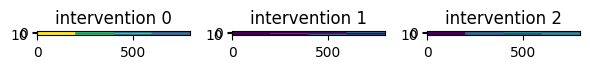

In [2]:
# generate data

## to generate data, first choose the data generator "get_sales_data", and choose seed, N(number of stores), and T (number of timesteps)
N = 20
T = 800
I = 3
seed = 6

data = get_sales_data(seed=seed, N=N, T=T)
## generate full data
tensor, full_df = data.generate([0, T - 1])


# choose assignment pattern, i.e., SI which correspond to the sparsity pattern considered in the Synthetic intervention paper
data_assignment =  sales_data_staggering_assignment
periods = data_assignment(data, seed=seed, T=data.max_timesteps)
_, df = data.auto_subsample(periods, tensor, full_df)

mask = data.mask
mask = mask.astype(bool)

# plot the tensor under the three interventions (the number 3 is chosen in the get_sales_data function)
fig, axes = plt.subplots(1,3, figsize = (6,10))
for i in range(3):
        axes[ i].imshow(mask[:,:,i,0])
        axes[ i].set_title(f"intervention {i}")
plt.tight_layout()

In [243]:
def pagify(tensor, L):
    N, T, I, _ = tensor.shape
    m = T//L
    assert T%L == 0, "choose L that is multiple of T"
    pagified_tensor = np.zeros([L*N, m*I])
    for n in range(N):
        series = tensor[n,:,:,0]
        pagified = series.reshape([L, m*I], order = "F")
        pagified_tensor[L*n:L*(n+1),:] = pagified
    return pagified_tensor

def unpagify(matrix, L, N, T, I):
    tensor = np.zeros([N, T, I, 1])
    for n in range(N):
        series = matrix[L*n:L*(n+1),:].reshape([T,I], order = "F")
        tensor[n, :,:, 0] = series
    return tensor


def pagify_h(tensor, L):
    N, T, I, _ = tensor.shape
    m = T//L
    assert T%L == 0, "choose L that is multiple of T"
    pagified_tensor = np.zeros([L, N*m*I])
    for n in range(N):
        for d in range(I):
            series = tensor[n,:,d,0]
            pagified = series.reshape([m,L], order = "F")
            index = n * I + d 
            pagified_tensor[:,index*m:(index+1)*m] = pagified.T
    return pagified_tensor

def unpagify_h(matrix, L, N, T, I):
    tensor = np.zeros([N, T, I, 1])
    m = T//L
    for n in range(N):
        for d in range(I):
            index = n * I + d 
            series = matrix[:,index*m:(index+1)*m]
            tensor[n, :, d, 0] = series.flatten()
    return tensor




(200, 240)

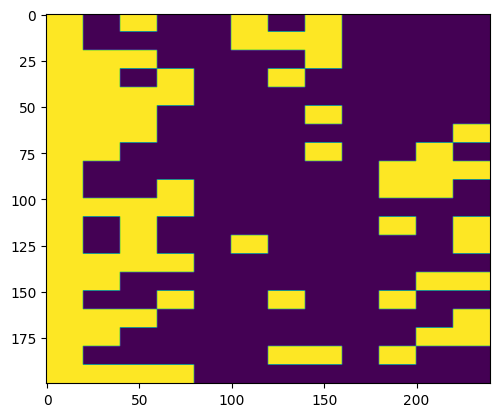

In [244]:
L = 10
mask_m = pagify(mask, L)

plt.imshow(mask_m)
mask_m.shape

(200, 240)

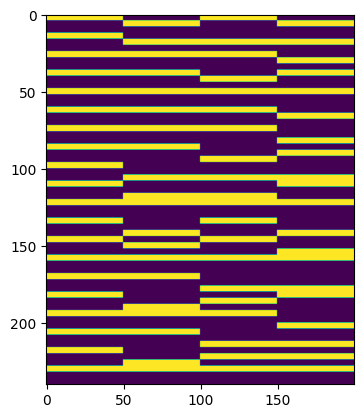

In [245]:
L = 200
mask_m = pagify_h(mask, L)

plt.imshow(mask_m[:,:].T)
mask_m.shape

In [4]:
model = SNN(verbose=False)
observation = np.array(tensor)
observation[...,0] += 0.1*np.nanmean(observation)*np.random.randn(observation.shape[0], observation.shape[1], observation.shape[2]) 
observation[~mask] = np.nan
matrix_t = model._tensor_to_matrix(observation[...], N, T, I)
filled_matrix = model._fit_transform(matrix_t)
filled_tensor  = model._matrix_to_tensor(filled_matrix, N, T, I)
# filled_tensor[np.isnan(filled_tensor)] = np.nanmean(obs_m)
        

In [6]:
L = 10
model = SNN(verbose=False, L = L)
matrix_t = model._tensor_to_matrix(observation[...], N, T, I)
filled_matrix = model._fit_transform(matrix_t)
filled_m   = model._matrix_to_tensor(filled_matrix, N, T, I)


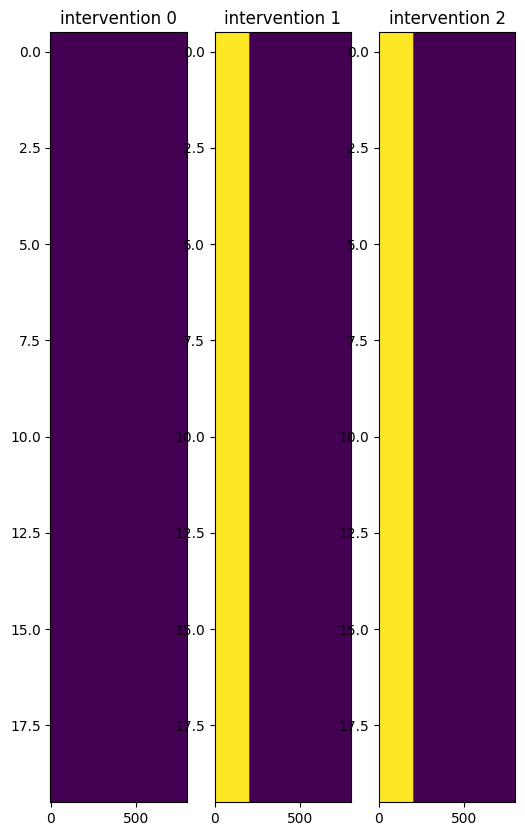

In [7]:
fig, axes = plt.subplots(1,3, figsize = (6,10))
for i in range(3):
        axes[ i].imshow(np.isnan(filled_tensor[:,:,i]), aspect = "auto")
        axes[ i].set_title(f"intervention {i}")

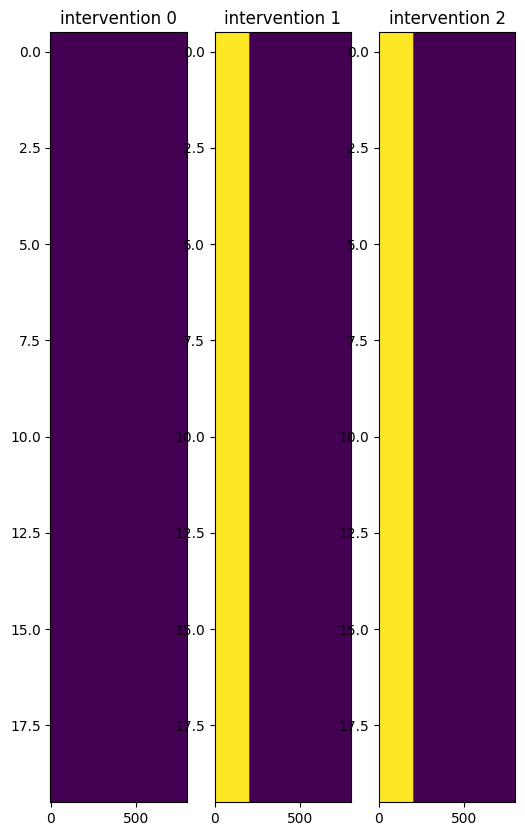

In [8]:
fig, axes = plt.subplots(1,3, figsize = (6,10))
for i in range(3):
        axes[ i].imshow(np.isnan(filled_m[:,:,i]), aspect = "auto")
        axes[ i].set_title(f"intervention {i}")

In [9]:
norm = np.square(tensor).mean()
np.nanmean(np.square(filled_m - tensor[:]))/norm,  np.nanmean(np.square(filled_tensor - tensor[:]))/norm

(0.01648714374433842, 0.03238603335823963)

In [12]:
valid_tensor = ((~mask[...]) & ~np.isnan(filled_tensor))
print("flattened", r2_score(filled_m[valid_tensor].flatten(), tensor[valid_tensor].flatten()))
# r2_score(filled_mh[validh].flatten(), tensor_mh[validh].flatten()), 
print(r2_score(filled_tensor[valid_tensor].flatten(), tensor[:][valid_tensor].flatten()))

flattened 0.8137344476637235
0.6457177560797795


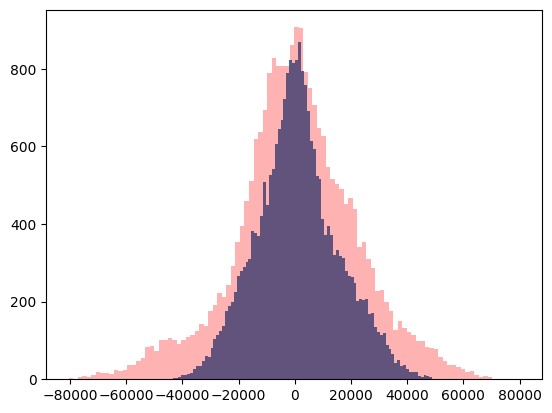

In [14]:
plt.hist(filled_m[valid_tensor].flatten() - tensor[valid_tensor].flatten(),100)
plt.hist(filled_tensor[valid_tensor].flatten() - tensor[valid_tensor].flatten(),100, alpha = 0.3, color ='r')
plt.show()